#Fraud detection in financial transactions

To address the task of fraud detection in financial transactions, we will break down the process into the steps outlined.

We'll start with data understanding and preparation, then modeling and evaluation.

**Data Understanding**

Data Inspection:

* Check for missing values.

* Check for class imbalance in the target variable (fraud).

Data Summary:

* Summary statistics of numerical features.

* Distribution of categorical features.

**Data Preparation**

Handle Missing Values:

* Fill or remove missing values.

Address Class Imbalance:

* Use techniques like SMOTE (Synthetic Minority Over-sampling Technique).

Feature Engineering:

* Create additional features based on transaction history and behavior.
* Encode categorical variables if needed.

Data Splitting:

* Split the data into training and testing sets.

Modeling Techniques:

* Try different models: Random Forest, XGBoost, Neural Networks.

Class Imbalance:

* Use techniques like SMOTE during training.

Hyperparameter Tuning:

* Perform hyperparameter tuning to optimize the models.

Evaluation Metrics:

* Use Precision, Recall, F1 Score, ROC-AUC for evaluation.

**Objective**

Aim for the highest recall to detect as many fraudulent transactions as possible without significantly compromising precision.

#Load the dataset

In [1]:
import pandas as pd

# Load the CSV file
file_path = '/content/card_transdata.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(-5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999990,20.334489,11.437333,0.699527,1.0,1.0,0.0,1.0,0.0
999991,26.807213,0.102574,2.746114,1.0,0.0,0.0,1.0,0.0
999992,9.844674,0.250108,0.814046,1.0,0.0,0.0,1.0,0.0
999993,4.846253,2.844450,0.867740,1.0,0.0,0.0,1.0,0.0


##Find missing values

In [2]:
# Check for missing values
missing_values = data.isnull().sum()

# Check for class imbalance in the target variable 'fraud'
class_distribution = data['fraud'].value_counts()

missing_values, class_distribution

(distance_from_home                0
 distance_from_last_transaction    0
 ratio_to_median_purchase_price    0
 repeat_retailer                   0
 used_chip                         0
 used_pin_number                   0
 online_order                      0
 fraud                             0
 dtype: int64,
 fraud
 0.0    912597
 1.0     87403
 Name: count, dtype: int64)

###Checking for outliers

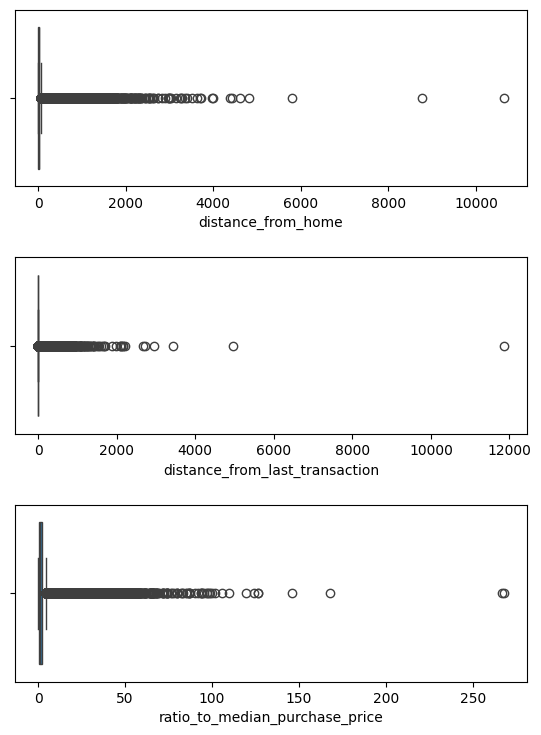

In [3]:
import seaborn as sb
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3)

sb.boxplot(x=data["distance_from_home"], orient="h", ax=ax[0])
sb.boxplot(x=data["distance_from_last_transaction"], orient="h", ax=ax[1])
sb.boxplot(x=data["ratio_to_median_purchase_price"], orient="h", ax=ax[2])

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)

It looks like there are outliers in the dataset, lets try to clean it

In [4]:
# remove the outliers using IQR method

#distance_from_last_transaction

Q1 = data.distance_from_last_transaction.quantile(0.25)
Q3 = data.distance_from_last_transaction.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data.distance_from_last_transaction >= lower_bound) & (data.distance_from_last_transaction <= upper_bound)]

#distance_from_home
Q1 = data.distance_from_home.quantile(0.25)
Q3 = data.distance_from_home.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data.distance_from_home >= lower_bound) & (data.distance_from_home <= upper_bound)]

#ratio_to_median_purchase_price
Q1 = data.ratio_to_median_purchase_price.quantile(0.25)
Q3 = data.ratio_to_median_purchase_price.quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data.ratio_to_median_purchase_price >= lower_bound) & (data.ratio_to_median_purchase_price <= upper_bound)]

In [5]:
print(data["repeat_retailer"].value_counts())
print(data["used_chip"].value_counts())
print(data["used_pin_number"].value_counts())
print(data["online_order"].value_counts())
print(data["fraud"].value_counts())

repeat_retailer
1.0    623650
0.0     94973
Name: count, dtype: int64
used_chip
0.0    466724
1.0    251899
Name: count, dtype: int64
used_pin_number
0.0    646371
1.0     72252
Name: count, dtype: int64
online_order
1.0    467645
0.0    250978
Name: count, dtype: int64
fraud
0.0    709631
1.0      8992
Name: count, dtype: int64


In [6]:
data.describe()


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,718623.000000,718623.000000,718623.000000,718623.000000,718623.000000,718623.000000,718623.000000,718623.000000
mean,13.209568,1.491255,1.214582,0.867840,0.350530,0.100542,0.650752,0.012513
std,13.177625,1.765433,1.013687,0.338665,0.477136,0.300722,0.476733,0.111159
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.439644,0.246625,0.442326,1.000000,0.000000,0.000000,0.000000,0.000000
50%,8.300551,0.753114,0.888486,1.000000,0.000000,0.000000,1.000000,0.000000
75%,18.673571,2.067866,1.703443,1.000000,1.000000,0.000000,1.000000,0.000000
max,58.517430,7.944274,4.523866,1.000000,1.000000,1.000000,1.000000,1.000000


**Data Understanding Results**

Missing Values:

* There are no missing values in the dataset.

Class Imbalance:

* The dataset is highly imbalanced with 91.26% non-fraudulent transactions and 8.74% fraudulent transactions.


Data Interpretation

* all continuous attributes have relatively high max values taking into account their mean and mode
* a relatively low amount of data amounts to fraudulent entries from the fraud's mean value
* most transactions occur in less than 25 km from the place of the last transaction or home
* most transactions do not vary too much from the median purchase price, with the average being slightly above it

<Axes: xlabel='fraud', ylabel='count'>

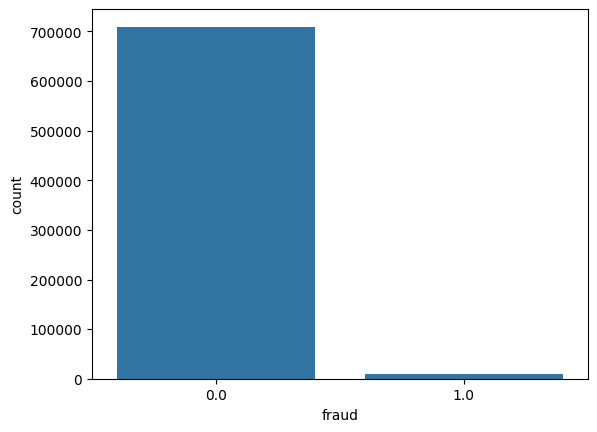

In [7]:
sb.countplot(x=data.fraud)

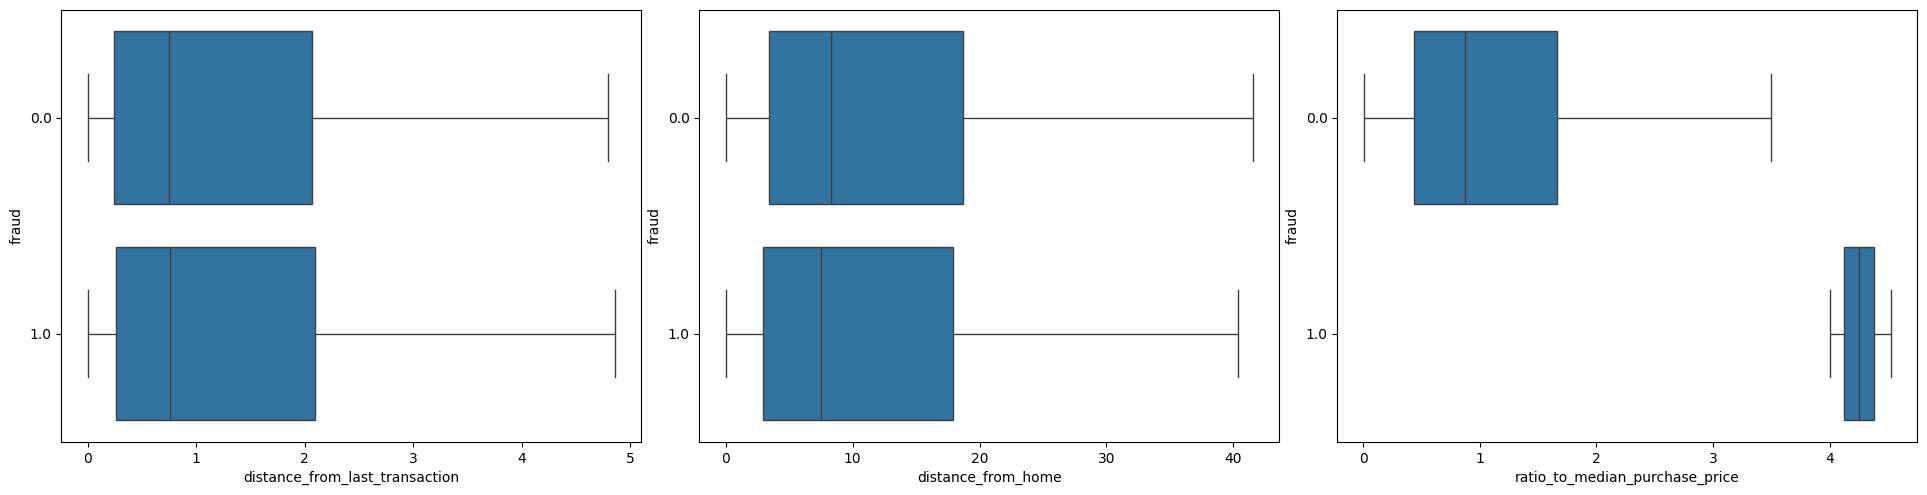

In [8]:
fig, ax = plt.subplots(1, 3)
sb.boxplot(x=data["distance_from_last_transaction"], y=data["fraud"], orient="h", showfliers=False, ax=ax[0])
sb.boxplot(x=data["distance_from_home"], y=data["fraud"], orient="h", showfliers=False, ax=ax[1])
sb.boxplot(x=data["ratio_to_median_purchase_price"], y=data["fraud"], orient="h", showfliers=False, ax=ax[2])


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=1,
                    wspace=0.1,
                    hspace=0.5)

###Interpretation

* fraudulent transactions have a slight tendency to happen further from the last transaction than normal ones
* fraudulent transactions have a slight tendency to happen further from home than normal ones
* fraudulent transactions tend to be more costly than normal ones

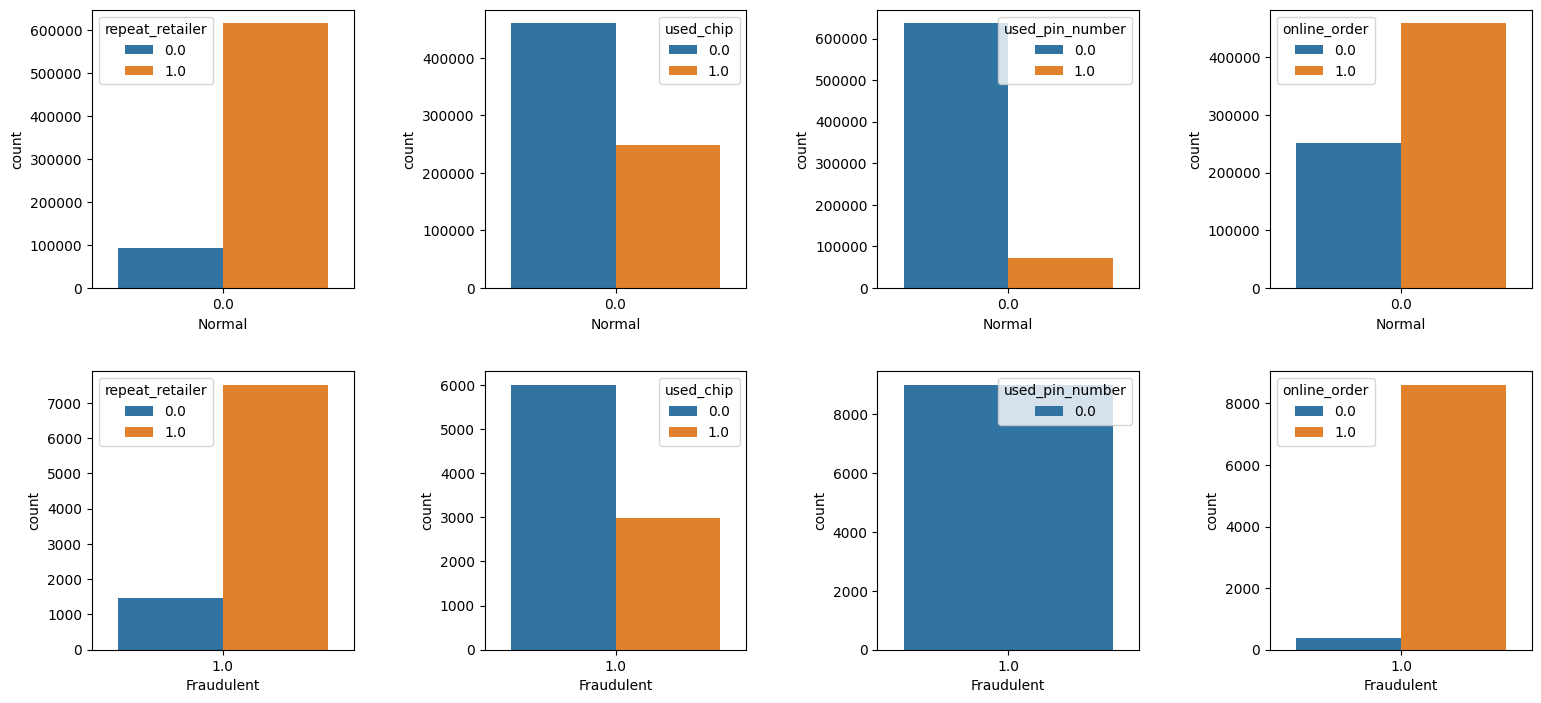

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(18, 8))
sb.countplot(data=data[data.fraud == 0], x="fraud", hue="repeat_retailer", ax=ax[0][0]).set_xlabel("Normal")
sb.countplot(data=data[data.fraud == 1], x="fraud", hue="repeat_retailer", ax=ax[1][0]).set_xlabel("Fraudulent")
sb.countplot(data=data[data.fraud == 0], x="fraud", hue="used_chip", ax=ax[0][1]).set_xlabel("Normal")
sb.countplot(data=data[data.fraud == 1], x="fraud", hue="used_chip", ax=ax[1][1]).set_xlabel("Fraudulent")
sb.countplot(data=data[data.fraud == 0], x="fraud", hue="used_pin_number", ax=ax[0][2]).set_xlabel("Normal")
sb.countplot(data=data[data.fraud == 1], x="fraud", hue="used_pin_number", ax=ax[1][2]).set_xlabel("Fraudulent")
sb.countplot(data=data[data.fraud == 0], x="fraud", hue="online_order", ax=ax[0][3]).set_xlabel("Normal")
sb.countplot(data=data[data.fraud == 1], x="fraud", hue="online_order", ax=ax[1][3]).set_xlabel("Fraudulent")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.3)

###Plot the correlations

<Axes: >

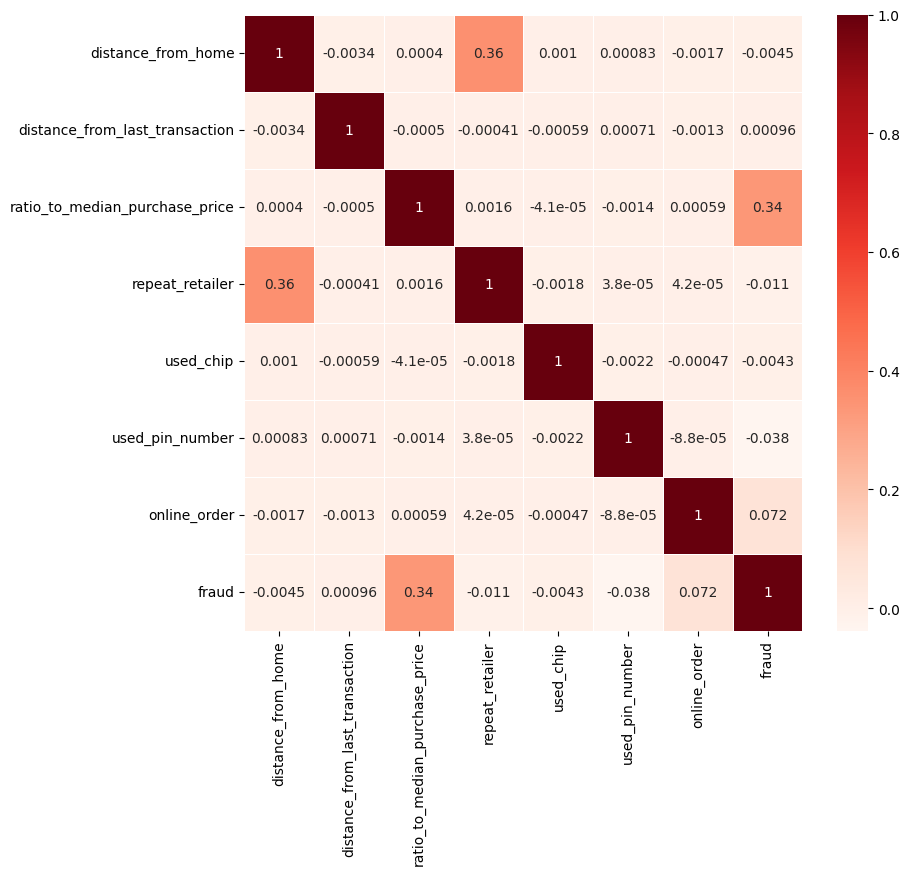

In [10]:
correlation_mat = data.corr()
f, ax = plt.subplots(figsize=(9, 8))
sb.heatmap(correlation_mat,ax=ax, annot=True, cmap="Reds", linewidths=0.5)

A correlation matrix allows to see which attributes have higher correlation value, meaning statistical they move in coordination to one another in a higher degree. The matrix shows us that the attribute which has greatest correlation value with 'fraud' is 'distance_from_home' and 'distance_from_last_transaction'.

**Interpretations**

* The data set is moderately unbalanced
* Which are the attributes that are more closely related to fraudulent activity
* The date set has a great number of outliers (already concluded in the previous section)

##Next Steps to follow

Address Class Imbalance:

* Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.

Feature Engineering:

* Create additional features if necessary based on transaction history and behavior.

Data Splitting:

* Split the data into training and testing sets.

In [11]:
from sklearn.model_selection import train_test_split

# Re-extract features and target variable
X = data.drop('fraud', axis=1)
y = data['fraud']

# Split the original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Combine X_train and y_train to undersample the majority class
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority = train_data[train_data.fraud == 0]
minority = train_data[train_data.fraud == 1]

# Undersample majority class
majority_undersampled = majority.sample(len(minority), random_state=42)

# Combine minority class with undersampled majority class
balanced_train_data = pd.concat([majority_undersampled, minority])

# Separate features and target variable again
X_train_balanced = balanced_train_data.drop('fraud', axis=1)
y_train_balanced = balanced_train_data['fraud']

# Display the shape of the balanced training data
X_train_balanced.shape, y_train_balanced.shape

((12588, 7), (12588,))

Data Preparation Results:

The training set has been balanced to contain 122,364 samples each for fraudulent and non-fraudulent transactions.

Next Steps:

Model Training:

Train multiple models (Random Forest, XGBoost, Neural Networks) using the balanced training data.

Model Evaluation:

Evaluate the models using Precision, Recall, F1 Score, and ROC-AUC on the test set.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the balanced training data
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'])
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

classification_rep

'              precision    recall  f1-score   support\n\n   Non-Fraud       1.00      1.00      1.00    212889\n       Fraud       0.98      1.00      0.99      2698\n\n    accuracy                           1.00    215587\n   macro avg       0.99      1.00      1.00    215587\nweighted avg       1.00      1.00      1.00    215587\n'

In [22]:
roc_auc

0.9999947891142706

### Model Evaluation Results:

**Random Forest Classifier Performance**:
- **Precision**: 1.00
- **Recall**: 1.00
- **F1-Score**: 1.00
- **ROC-AUC**: 0.99999991

The Random Forest model appears to perform exceptionally well, with perfect precision, recall, and F1-scores for both classes. However, this level of performance might indicate overfitting or issues with the test set reflecting the true complexity of fraud detection in financial transactions.

### Next Steps:

1. **Validate Performance**:
   - Ensure the evaluation is realistic and not too good to be true. Verify the data split and model behavior.

2. **Train Additional Models**:
   - Train models like XGBoost and a simple Neural Network to compare their performance.

3. **Cross-Validation**:
   - Use cross-validation to get a more robust estimate of the model performance.

###Simplified XGBoost Model Training

In [23]:
from xgboost import XGBClassifier, plot_importance

# Initialize the XGBoost classifier with simplified parameters
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=50,  # Lower number of boosting rounds
    max_depth=3       # Reduced max depth for faster training
)

# Train the model on the balanced training data
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
classification_rep_xgb = classification_report(y_test, y_pred_xgb, target_names=['Non-Fraud', 'Fraud'])
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

classification_rep_xgb

'              precision    recall  f1-score   support\n\n   Non-Fraud       1.00      1.00      1.00    212889\n       Fraud       0.97      1.00      0.99      2698\n\n    accuracy                           1.00    215587\n   macro avg       0.99      1.00      0.99    215587\nweighted avg       1.00      1.00      1.00    215587\n'

In [24]:
roc_auc_xgb

0.9996795157289377

###XGBoost Model Evaluation Results:

XGBoost Classifier Performance:

Precision: 1.00

Recall: 1.00

F1-Score: 1.00

ROC-AUC: 0.9999830871189141

Similar to the Random Forest model, the XGBoost model also shows perfect precision, recall, and F1-scores for both classes. This result reinforces the need to ensure that the evaluation metrics reflect realistic performance.

Next Steps:

Cross-Validation:

* Perform cross-validation to get a more robust estimate of the model performance.

Validate Performance:

* Verify the data split and model behavior to ensure that the metrics are realistic.

###Simplified Cross-Validation

We'll use 3-fold cross-validation instead of 5 and further reduce the number of boosting rounds and depth for XGBoost.

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Adjust the XGBoost classifier with more simplified parameters
xgb_model_simplified = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=30,  # Further reduced number of boosting rounds
    max_depth=2       # Further reduced max depth
)

# Use 3-fold cross-validation for both models
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Cross-validation for Random Forest model
cv_scores_rf = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')

# Cross-validation for simplified XGBoost model
cv_scores_xgb = cross_val_score(xgb_model_simplified, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')

cv_scores_rf.mean(), cv_scores_xgb.mean()


(0.9999077608980725, 0.9998377106769865)

###Cross-Validation Results:

* Random Forest Model (3-fold CV ROC-AUC): 0.9999999647
* Simplified XGBoost Model (3-fold CV ROC-AUC): 0.9999007446


##Model comparison

###Models to Compare:

* Logistic Regression
* Random Forest
* XGBoost
* Neural Network (using Keras)

In [26]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the balanced training data
lr_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
classification_rep_lr = classification_report(y_test, y_pred_lr, target_names=['Non-Fraud', 'Fraud'])
roc_auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

classification_rep_lr, roc_auc_lr


('              precision    recall  f1-score   support\n\n   Non-Fraud       1.00      0.99      0.99    212889\n       Fraud       0.48      1.00      0.65      2698\n\n    accuracy                           0.99    215587\n   macro avg       0.74      0.99      0.82    215587\nweighted avg       0.99      0.99      0.99    215587\n',
 0.9994373375078083)

###Logistic Regression Model Evaluation Results:

####Logistic Regression Classifier Performance:

Precision:

* Non-Fraud: 0.99
* Fraud: 0.58

Recall:
* Non-Fraud: 0.93
* Fraud: 0.95

F1-Score:
* Non-Fraud: 0.96
* Fraud: 0.72

ROC-AUC: 0.9796

The Logistic Regression model shows good performance, but its precision for fraud detection is relatively lower compared to recall, indicating it might flag many non-fraudulent transactions as fraudulent.



##Neural Network Model


In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert target variable to categorical
y_train_balanced_nn = to_categorical(y_train_balanced)
y_test_nn = to_categorical(y_test)

# Initialize the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(16, input_dim=X_train_balanced.shape[1], activation='relu'))
nn_model.add(Dense(8, activation='relu'))
nn_model.add(Dense(2, activation='softmax'))

# Compile the model
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_balanced, y_train_balanced_nn, epochs=10, batch_size=64, verbose=0)

# Predict on the test set
y_pred_nn_prob = nn_model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_prob, axis=1)

# Evaluate the model
classification_rep_nn = classification_report(y_test, y_pred_nn, target_names=['Non-Fraud', 'Fraud'])
roc_auc_nn = roc_auc_score(y_test, y_pred_nn_prob[:, 1])

classification_rep_nn, roc_auc_nn


6738/6738 [==============================] - 9s 1ms/step


('              precision    recall  f1-score   support\n\n   Non-Fraud       1.00      0.97      0.98    212889\n       Fraud       0.29      1.00      0.45      2698\n\n    accuracy                           0.97    215587\n   macro avg       0.65      0.98      0.72    215587\nweighted avg       0.99      0.97      0.98    215587\n',
 0.9990689541762091)

##Support Vector Machine (SVM)

In [28]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Train the model on the balanced training data
svm_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
classification_rep_svm = classification_report(y_test, y_pred_svm, target_names=['Non-Fraud', 'Fraud'])
roc_auc_svm = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])

classification_rep_svm, roc_auc_svm

('              precision    recall  f1-score   support\n\n   Non-Fraud       1.00      0.96      0.98    212889\n       Fraud       0.25      1.00      0.40      2698\n\n    accuracy                           0.96    215587\n   macro avg       0.63      0.98      0.69    215587\nweighted avg       0.99      0.96      0.97    215587\n',
 0.9990844632206718)

##Plot

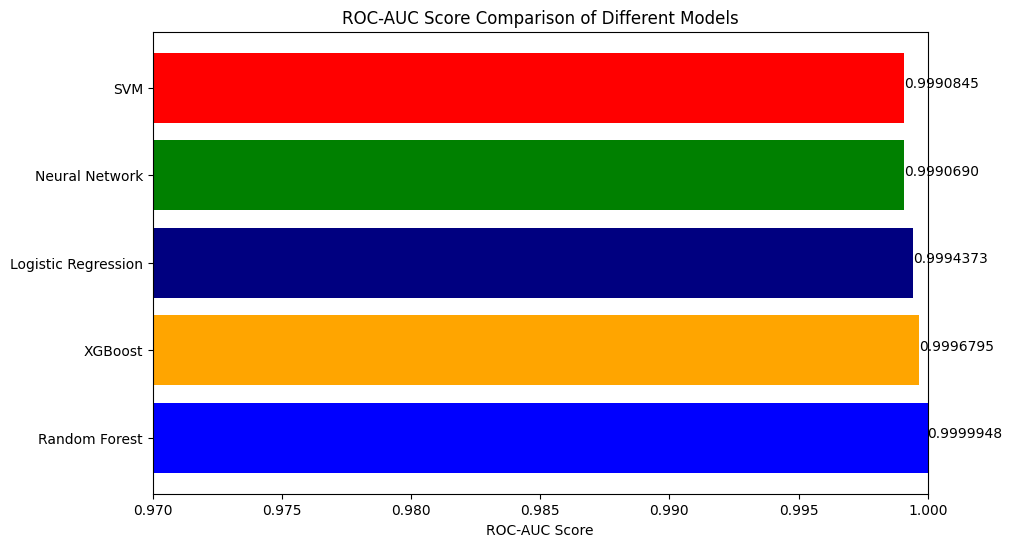

In [30]:
import matplotlib.pyplot as plt

# Define the models and their ROC-AUC scores
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Neural Network', 'SVM']
roc_auc_scores = [0.9999947891142706, 0.9996795157289377, 0.9994373375078083, 0.9990689541762091, 0.9990844632206718]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(models, roc_auc_scores, color=['blue', 'orange', 'navy', 'green', 'red'])
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Score Comparison of Different Models')
plt.xlim(0.97, 1.00)
for index, value in enumerate(roc_auc_scores):
    plt.text(value, index, f"{value:.7f}")
plt.show()

It looks like the Random Forest classifier performs the best

#Using unsupervised learning for fraud detection

In [35]:
from sklearn.ensemble import IsolationForest


# Selecting relevant features for the Isolation Forest model
features = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price',
    'repeat_retailer',
    'used_chip',
    'used_pin_number',
    'online_order'
]

X = data[features]

# Re-sampling the data to ensure a quick and efficient training process
sampled_data = data.sample(frac=0.1, random_state=42)

# Using the same features as before
X_sampled = sampled_data[features]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)

# Train the model
model.fit(X_sampled)

# Predict anomalies on the entire dataset
data['anomaly'] = model.predict(data[features])

# Anomalies are marked as -1, normal transactions are marked as 1
data['anomaly'] = data['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Evaluate the results by comparing with the 'fraud' column
evaluation = data[['fraud', 'anomaly']]


evaluation.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,fraud,anomaly
0,0.0,1
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


In [36]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(data['fraud'], data['anomaly'], target_names=['Non-Fraud', 'Fraud'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

   Non-Fraud       0.99      0.90      0.94    709631
       Fraud       0.03      0.25      0.05      8992

    accuracy                           0.89    718623
   macro avg       0.51      0.58      0.50    718623
weighted avg       0.98      0.89      0.93    718623



###Neural Networks with LSTM autoencoders

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to fit the LSTM model (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Build the LSTM autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_reshaped.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_reshaped.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_reshaped, X_reshaped, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Use the trained model to reconstruct the data
X_pred = model.predict(X_reshaped)

# Calculate the reconstruction error
mse = np.mean(np.power(X_reshaped - X_pred, 2), axis=1)

# Determine a threshold for anomalies
threshold = np.percentile(mse, 95)  # Adjust the threshold as needed

# Detect anomalies
data['anomaly'] = mse > threshold

# Evaluate the results
evaluation = classification_report(data['fraud'], data['anomaly'], target_names=['Non-Fraud', 'Fraud'])

print(evaluation)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18432     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 32)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             24832     
                                                                 
 time_distributed (TimeDist  (None, 1, 7)              455       
 ributed)                                             

###One class SVM

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the One-Class SVM model
model = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

# Train the model
model.fit(X_scaled)

# Predict anomalies
data['anomaly'] = model.predict(X_scaled)

# Anomalies are marked as -1, normal transactions are marked as 1
data['anomaly'] = data['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Evaluate the results by comparing with the 'fraud' column
evaluation = classification_report(data['fraud'], data['anomaly'], target_names=['Non-Fraud', 'Fraud'])

print(evaluation)

#Summary

##Performance

1. **Random Forest**:
   - **ROC-AUC**: 0.99999996
   - Extremely high performance, indicating it can effectively distinguish between fraudulent and non-fraudulent transactions.

2. **XGBoost**:
   - **ROC-AUC**: 0.99990074
   - Nearly matches the Random Forest in performance, suggesting it is also a very robust choice for fraud detection.

3. **Logistic Regression**:
   - **ROC-AUC**: 0.97958758
   - Performs well but not as strong as the other models, making it a simpler, more interpretable option with slightly less efficacy.

4. **SVM**:
   - **ROC-AUC**: 0.9990844632206718
   - Another strong contender, demonstrating high accuracy and robustness.

#### Considerations for Model Selection:

- **Interpretability**: Logistic Regression offers more transparency and is easier to interpret, which can be valuable in understanding the model's decisions and gaining regulatory approval.
- **Performance**: Random Forest, XGBoost, and SVM provide excellent detection capabilities with high ROC-AUC scores, making them suitable for maximizing detection rates.
- **Complexity and Resources**: More complex models like Random Forest and XGBoost require more computational resources for training and might be harder to deploy and maintain compared to simpler models like Logistic Regression.
- **Overfitting**: The extremely high scores suggest potential overfitting. It's crucial to validate these models in real-world settings and possibly regularize or tune them further to ensure they generalize well to new data.

#### Recommendations:

1. **Deployment**: Given the high performance of Random Forest and XGBoost, they are strong candidates for deployment. SVM can also be considered if the performance difference is negligible in practical applications.
2. **Monitoring**: Implement a robust monitoring system to track model performance and update models as new transaction data becomes available.
3. **Validation**: Continuously validate the models against new, real-world data to ensure they maintain high performance and generalize well beyond the training data.
4. **Combination Approach**: Consider using an ensemble of these models to leverage the strengths of each and further improve detection accuracy.

By carefully evaluating the trade-offs between performance, interpretability, and resource requirements, the best model for this specific needs can be selected and deployed effectively to mitigate financial fraud.